In [1]:
!RUST_BACKTRACE=1 cargo run -- ../models/quadrotor.mo -t ../templates/sympy.jinja > quadrotor_sympy.py

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.15s
     Running `/home/jgoppert/git/rumoca_parol/target/debug/rumoca ../models/quadrotor.mo -t ../templates/sympy.jinja`


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import quadrotor_sympy
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [4]:
model = quadrotor_sympy.Model()

Matrix([[u], [u], [u], [u]])


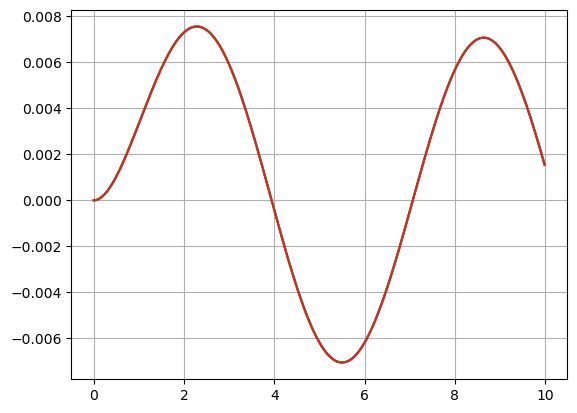

In [5]:
model.p0['m1_tau'] = 100
model.p0['m2_tau'] = 100
model.p0['m3_tau'] = 100
model.p0['m4_tau'] = 100

def u(t):
    return np.array([1*np.sin(t)])

t = np.arange(0, 10, 0.01)
res = model.simulate(t, u)

plt.figure()
plt.plot(res['t'], res['x'].T);
#plt.plot(t, u(t).T)
plt.grid()